In [2]:
import numpy as np
from torchvision import datasets, transforms
from PIL import Image
from IPython.display import display
from model.unet import Unet
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import os

In [3]:
device = 'cuda'

unet = Unet(dim=128, mults=[1, 2, 4, 8], channel_scale=1).to(device)

In [4]:
batch_size = 128
learning_rate = 0.00005
epochs = 1000
total_timesteps = 1000
beta_0 = 0.0001
beta_T = 0.02
sampling_steps = 1000
output_dir = './logs_mnist_reweight'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    os.makedirs(f"{output_dir}/valid_imgs/")
    os.makedirs(f"{output_dir}/weights/")

optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, betas=(0.9, 0.999))

trainer = {
    'train_losses': [],
    'valid_losses': [],
    'valid_images': [],
}

In [5]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                  transform=transforms.Compose([
                      transforms.Resize(32),
                      transforms.ToTensor(),
                      transforms.Lambda(lambda t: (t * 2) - 1)
                  ])
                 ),
    batch_size=batch_size, shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=False, download=True,
                  transform=transforms.Compose([
                      transforms.Resize(32),
                      transforms.ToTensor(),
                      transforms.Lambda(lambda t: (t * 2) - 1)
                  ])
                 ),
    batch_size=batch_size, shuffle=False
)


469
79
2
torch.Size([128, 1, 32, 32])
torch.Size([128])
tensor(4)


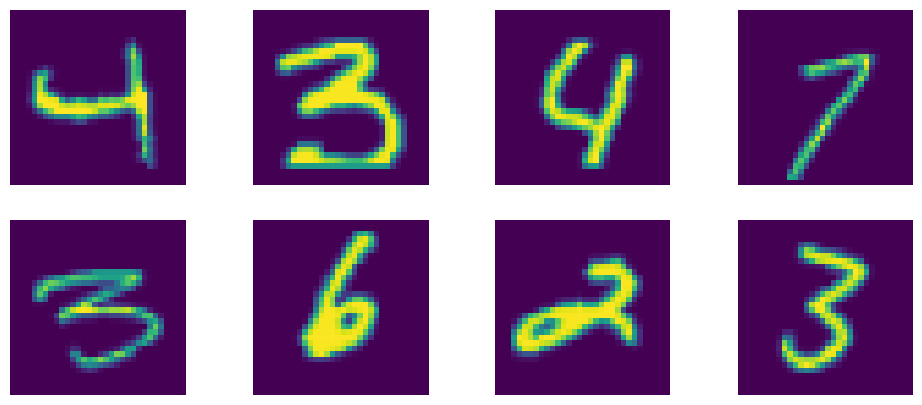

In [6]:
# 시각화
def visualize(img, epoch=0):
    if img.shape[0] == 1:
        plt.figure(figsize=(2,2))
        img = img.squeeze()
        plt.imshow(img)
        plt.show()
    elif img.shape[0]>1 and len(img.shape)>2:
        fig, axes = plt.subplots(2, 4, figsize=(12, 5))
        for i, ax in enumerate(axes.flat):
            ax.imshow(img[i].squeeze())
            ax.axis('off')
        plt.savefig(f'{output_dir}/valid_imgs/valid_{epoch}.png')
        plt.show()
        plt.close()

# 데이터 체크
print(len(dataloader)) # 데이터셋 50,000개
print(len(dataloader_valid)) # 10,000개

data = next(iter(dataloader))
print(len(data))
print(data[0].shape)
print(data[1].shape)
print(data[1][0])

visualize(data[0]/2 + 0.5)

In [7]:
def linear_beta_schedule(timesteps=1000):
    betas = torch.linspace(beta_0, beta_T, steps=timesteps+1)

    alphas = 1. - betas
    alphas_bar = torch.cumprod(alphas, dim=0)

    return betas, alphas, alphas_bar

In [8]:
betas, alphas, alphas_bar = linear_beta_schedule(total_timesteps)

def x_t_sample(x_0, timesteps, noise):
    return torch.stack([torch.sqrt(alphas_bar[t])*x_0[idx] + torch.sqrt(1-alphas_bar[t])*noise[idx] for idx, t in enumerate(timesteps)])

def x_t_1_sample(x_t, timesteps, predicted_noise, z):
    moved_mean = torch.stack([x_t[idx] - (1-alphas[t])/(torch.sqrt(1-alphas_bar[t])) * predicted_noise[idx] for idx, t in enumerate(timesteps)])
    return torch.stack([1/torch.sqrt(alphas[t]) * moved_mean[idx] + torch.sqrt(betas[t]) * z[idx] for idx, t in enumerate(timesteps)])

def write(text):
    with open(f'{output_dir}/logs.txt', 'a') as file:
        file.write(text)

In [9]:
from datetime import datetime
write(f"\n\nTraining start : {datetime.today().strftime('%Y-%m-%d %H:%M')}\n\n")

for epoch in range(epochs):
    unet.train()
    epoch_loss = 0
    # tqdm_bar = tqdm(total=len(dataloader), desc="Diffusion Training")
    
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        
        x_0 = data[0].to(device)
        b, c, h, w = x_0.shape
                
        timesteps = torch.randint(0, 1001, (b,))
        added_noise = torch.randn_like(x_0)
        
        x_t = x_t_sample(x_0, timesteps, added_noise)

        x_t = x_t.to(device)
        timesteps = timesteps.to(device)
        added_noise = added_noise.to(device)

        predicted_noise = unet(x_t, timesteps)
            
        loss = F.mse_loss(added_noise, predicted_noise)

        loss.backward()
        optimizer.step()
        # tqdm_bar.update()

        epoch_loss += loss.cpu().detach().item()

        if idx%100==99 and epoch>0:
            trainer['train_losses'].append(epoch_loss/idx)
    train_text=f'Epoch {epoch} Train loss - {epoch_loss/len(dataloader)}\n'
    write(train_text)
    
    del loss
    del predicted_noise
    del added_noise
    del timesteps
    del x_t
    torch.cuda.empty_cache()

    unet.eval()
    valid_loss = 0
    # tqdm_bar = tqdm(total=len(dataloader_valid), desc="Diffusion validation")
    do_clip = partial(torch.clamp, min = -1., max = 1.)
    with torch.no_grad():
        for idx, data in enumerate(dataloader_valid):
            x_0 = data[0].to(device)
            b, c, h, w = x_0.shape
            
            timesteps = torch.randint(0, 1001, (b,))
            added_noise = torch.randn_like(x_0)
            
            x_t = x_t_sample(x_0, timesteps, added_noise)
    
            x_t = x_t.to(device)
            timesteps = timesteps.to(device)
            added_noise = added_noise.to(device)
    
            predicted_noise = unet(x_t, timesteps)

            loss = F.mse_loss(added_noise, predicted_noise)
            valid_loss += loss.cpu().detach().item()
            # tqdm_bar.update()  

            if idx==0:
                # Inference Sampling
                x_t = torch.randn_like(x_0).to(device)
                for t in range(sampling_steps+1):
                    t = 1000 - t
                    timesteps = torch.tensor(t).repeat(b).to(device)
                    z = torch.randn_like(x_0)
                    predicted_noise = unet(x_t, timesteps)
                    
                    x_t_1 = x_t_1_sample(x_t, timesteps, predicted_noise, z)
                    x_t = x_t_1.to(device)
                    x_t = do_clip(x_t)
                trainer['valid_images'].append(x_t[:8].cpu().detach())
        
        del loss
        del predicted_noise
        del added_noise
        del timesteps
        del x_t
        torch.cuda.empty_cache()
        trainer['valid_losses'].append(valid_loss/len(dataloader_valid))

    if valid_loss/len(dataloader_valid) <= min(trainer['valid_losses']):
        torch.save(unet.state_dict(), f'{output_dir}/weights/model_{epoch}.pth')
    valid_text=f'Epoch {epoch} Validation loss - {valid_loss/len(dataloader_valid)}\n\n'
    write(valid_text)

    plt.plot(trainer['train_losses'])
    plt.savefig(f'{output_dir}/train_loss.png')
    plt.close()

    plt.plot(trainer['valid_losses'])
    plt.savefig(f'{output_dir}/valid_loss.png')
    plt.close()

    visualize(trainer['valid_images'][-1]/2 + 0.5, epoch=epoch)

KeyboardInterrupt: 

In [11]:
print(added_noise.shape)
print(predicted_noise.shape)

torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])


In [12]:
loss

tensor(0.8713, device='cuda:0', grad_fn=<MseLossBackward0>)

In [15]:
tloss = 0
for i in range(128):
    bloss = F.mse_loss(added_noise[i], predicted_noise[i]).cpu().detach().item()
    tloss += bloss

### Code Test

In [ ]:
x_0 = data[0]
print(x_0.shape)
b, c, h, w = x_0.shape
timesteps = torch.randint(0, 1000, (b,))
print(timesteps.shape)

added_noise = torch.randn_like(x_0)
print(added_noise.shape)

In [ ]:
x_t = x_t_sample(x_0, timesteps, added_noise)
x_t.shape

In [ ]:
x_t = x_t.to(device)
timesteps = timesteps.to(device)
predicted_noise = unet(x_t, timesteps)

In [ ]:
added_noise = added_noise.to(device)

loss = F.mse_loss(added_noise, predicted_noise)
print(loss)

In [ ]:
def x_t_1_sample(x_t, timesteps, predicted_noise, z):
    moved_mean = torch.stack([x_t[idx] - (1-alphas[t])/(torch.sqrt(1-alphas_bar[t])) * predicted_noise[idx] for idx, t in enumerate(timesteps)])
    return torch.stack([1/torch.sqrt(alphas[t]) * moved_mean[idx] + torch.sqrt(betas[t]) * z[idx] for idx, t in enumerate(timesteps)])

In [ ]:
x_0 = data[0]
print(x_0.shape)
b, c, h, w = x_0.shape
do_clip = partial(torch.clamp, min = -1., max = 1.)


x_T = torch.randn_like(x_0).to(device)
for t in tqdm(range(sampling_steps)):
    t=999-t
    timesteps = torch.tensor(t).repeat(b).to(device)
    z = torch.randn_like(x_0)
    predicted_noise = unet(x_T, timesteps)
    
    x_t_1 = x_t_1_sample(x_T, timesteps, predicted_noise, z.to(device))
    x_T = x_t_1.to(device)
    x_T = do_clip(x_T)

In [ ]:
print(1)

In [ ]:
visualize(x_T.cpu().detach()/2+0.5)

In [ ]:
x_T[:8].shape